# Residual Analysis

In [73]:
import pickle
import pathlib
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para análise estatística
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Biblioteca para testes estatísticos
import scipy.stats as stats

# Biblioteca para dividir os dados
from sklearn.model_selection import train_test_split

# Modelos de regressão
from sklearn.linear_model import LinearRegression

# Métricas de avaliação
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [74]:
# Definir o diretório de dados
DATA_DIR = pathlib.Path.cwd().parent / 'data'
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

# Carregar os dados limpos
with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

# Copiar os dados para manipulação
model_data = data.copy()

# Verificar informações do dataframe
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2877 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2877 non-null   category
 1   MS.Zoning        2877 non-null   category
 2   Lot.Frontage     2877 non-null   float64 
 3   Lot.Area         2877 non-null   float64 
 4   Lot.Shape        2877 non-null   category
 5   Land.Contour     2877 non-null   category
 6   Lot.Config       2877 non-null   category
 7   Land.Slope       2877 non-null   category
 8   Neighborhood     2877 non-null   category
 9   Bldg.Type        2877 non-null   category
 10  House.Style      2877 non-null   category
 11  Overall.Qual     2877 non-null   category
 12  Overall.Cond     2877 non-null   category
 13  Roof.Style       2877 non-null   category
 14  Mas.Vnr.Type     2877 non-null   category
 15  Mas.Vnr.Area     2877 non-null   float64 
 16  Exter.Qual       2877 non-null   category
 17  

In [75]:
# Identificar colunas ordinais
ordinal_columns = [col for col in model_data.select_dtypes('category').columns if model_data[col].cat.ordered]

# Codificar variáveis ordinais
for col in ordinal_columns:
    codes, _ = pd.factorize(model_data[col], sort=True)
    model_data[col] = codes

In [76]:
# Codificar variáveis nominais usando get_dummies com drop_first para evitar multicolinearidade
model_data = pd.get_dummies(model_data, drop_first=True)

In [77]:
# Separar as features e a variável alvo
X = model_data.drop(columns=['SalePrice'])
y = model_data['SalePrice']

# Dividir os dados
RANDOM_SEED = 42
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_SEED,
)

In [78]:
# Instanciar o modelo
model = LinearRegression()

# Treinar o modelo
model.fit(Xtrain, ytrain)

# Fazer previsões no conjunto de teste
ypred = model.predict(Xtest)

# Avaliar o modelo
rmse = np.sqrt(mean_squared_error(ytest, ypred))
mae = mean_absolute_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

RMSE: 0.061127758761018135
MAE: 0.034275144840119606
R²: 0.8804053013390893


In [79]:
# Calculando os resíduos
residuos = ytest - ypred

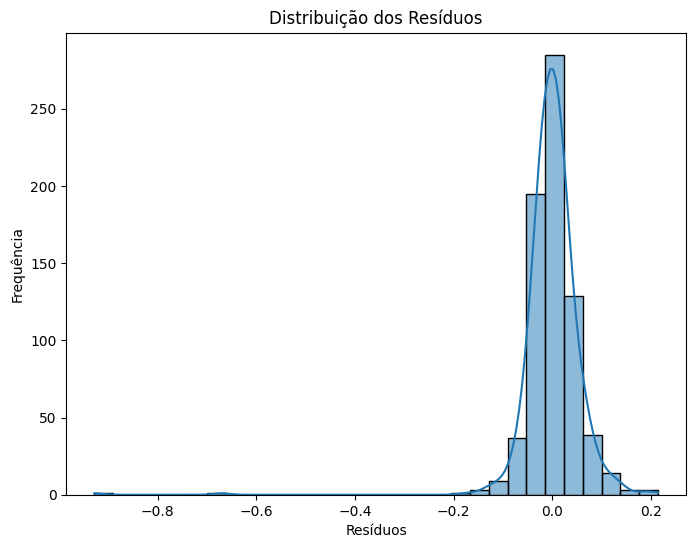

In [80]:
plt.figure(figsize=(8,6))
sns.histplot(residuos, kde=True, bins=30)
plt.xlabel('Resíduos')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.show()

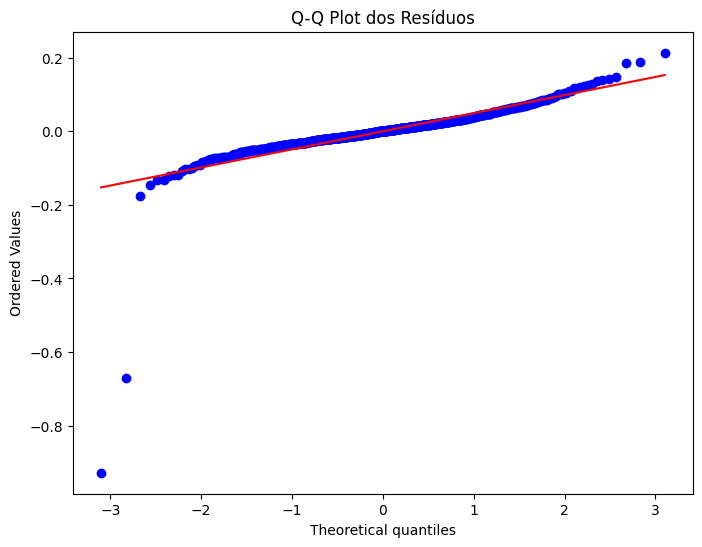

In [81]:
plt.figure(figsize=(8,6))
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q Plot dos Resíduos')
plt.show()

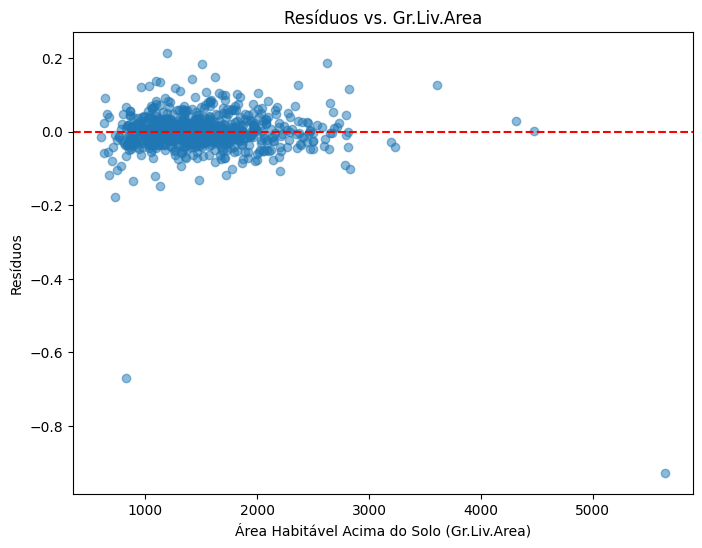

In [82]:
plt.figure(figsize=(8,6))
plt.scatter(Xtest['Gr.Liv.Area'], residuos, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Área Habitável Acima do Solo (Gr.Liv.Area)')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Gr.Liv.Area')
plt.show()

In [83]:
# Adicionar uma constante ao conjunto de teste
Xtest_const = sm.add_constant(Xtest)

# Realizar o teste de Breusch-Pagan
bp_test = sms.het_breuschpagan(residuos, Xtest_const)

bp_labels = ['Estatística LM', 'Valor-p LM', 'Estatística F', 'Valor-p F']
bp_results = dict(zip(bp_labels, bp_test))

print('Teste de Breusch-Pagan para Heterocedasticidade:')
for key, value in bp_results.items():
    print(f'{key}: {value}')

Teste de Breusch-Pagan para Heterocedasticidade:
Estatística LM: 466.07426193466944
Valor-p LM: 9.450789419223231e-31
Estatística F: 6.5702978866385875
Valor-p F: 1.698425017335275e-62


In [84]:
# Selecionar colunas numéricas
numerical_cols = Xtrain.select_dtypes(include=['float64', 'int64']).columns

# Criar um DataFrame com essas variáveis
Xtrain_num = Xtrain[numerical_cols]

# Adicionar uma constante
Xtrain_num_const = sm.add_constant(Xtrain_num)

# Calcular o VIF
vif_data = pd.DataFrame()
vif_data["Variável"] = Xtrain_num.columns
vif_data["VIF"] = [variance_inflation_factor(Xtrain_num_const.values, i+1) for i in range(len(Xtrain_num.columns))]

print('Valores do VIF para cada variável:')
print(vif_data)

Valores do VIF para cada variável:
           Variável       VIF
0      Lot.Frontage  1.382806
1          Lot.Area  1.479736
2         Lot.Shape  1.229938
3        Land.Slope  1.241372
4      Overall.Qual  3.832120
5      Overall.Cond  1.925654
6      Mas.Vnr.Area  1.439027
7        Exter.Qual  3.160795
8        Exter.Cond  1.275155
9      BsmtFin.SF.1       inf
10     BsmtFin.SF.2       inf
11      Bsmt.Unf.SF       inf
12    Total.Bsmt.SF       inf
13       Heating.QC  1.672911
14       Electrical  1.271311
15      X1st.Flr.SF       inf
16      X2nd.Flr.SF       inf
17  Low.Qual.Fin.SF       inf
18      Gr.Liv.Area       inf
19   Bsmt.Full.Bath  2.118130
20   Bsmt.Half.Bath  1.175704
21        Full.Bath  2.768237
22        Half.Bath  2.148468
23    Bedroom.AbvGr  2.582665
24    Kitchen.AbvGr  1.532842
25     Kitchen.Qual  2.623296
26    TotRms.AbvGrd  4.570884
27       Functional  1.203679
28       Fireplaces  1.584405
29      Garage.Cars  5.906068
30      Garage.Area  5.655652
31   

/Users/gabrielmendes/Documents/ProjetoAmes/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
# Ajustar o modelo usando statsmodels
modelo_sm = sm.OLS(ytrain, Xtrain_const).fit()

# Resumo do modelo
print(modelo_sm.summary())

Colunas categóricas ou do tipo object: Index([], dtype='object')
